# Demo training for Retinopathy detection

### Import libraries

In [4]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import pickle
import os

from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import scipy

### Functions definitions, load dataset into array, normalized the datase, build the model with augmentation and training

In [5]:
batch_size = 32 # Default value
epoch = 20  # Absurdly high, earlyStop implemented
initial_learning_rate = 0.001  # Default value
patience = 20 # See How it perform over epochs

folder_path = '../Database/2Organized' # Directory with photos small sample to test different settings

# Memory Growth for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

def load_data(folder_path):
    img_height = 512
    img_width = 512
    
    # Data Preprocessing
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        folder_path,
        target_size=(img_height, img_width),  # InceptionV3 input size 299 make it a bit larger
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        folder_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, validation_generator

def build_model(train_generator, validation_generator):    
    # InceptionV3 Model
    base_model = InceptionV3(weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freezing the base model layers
    for layer in base_model.layers:
        layer.trainable = False
        
    # Adjusted learning rate
    decay_steps = int(0.2 * len(train_generator))  # Use a 20% for learning rate
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(  
        initial_learning_rate, decay_steps=decay_steps, decay_rate=0.96, staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compiling the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def train_and_save_model(model_name, save_path, history_name):
    train_generator, validation_generator = load_data(folder_path)

    model = build_model(train_generator, validation_generator)
    
    # Create a callback that saves the model's weights
    keras_callbacks = [
        EarlyStopping(monitor='val_loss', patience=patience),
        ModelCheckpoint(f"{save_path}/{model_name}", monitor='val_loss', save_best_only=True, verbose=1)
    ]
    
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        epochs=epoch,
        shuffle=True,
        callbacks=[keras_callbacks]  # Pass callback to training
    )

    # Save the history
    with open(f"{save_path}/{history_name}", 'wb') as history_file:
        pickle.dump(history.history, history_file)

### Train the model with different values to compare

In [6]:
# List of batch sizes and learning rates to iterate over
batch_sizes = [64, 32] # Powers of 2 work better in GPU
initial_learning_rates = [0.01, 0.001] 

# tf.debugging.set_log_device_placement(True) # DEBUGGING

for batch in batch_sizes:
    for initial_learning_ratess in initial_learning_rates:
        batch_size = batch
        initial_learning_rate = initial_learning_ratess
                
        save_path = f"../TrainingX/Model_{batch_size}_{initial_learning_ratess}"
        model_name = f"Model_{batch_size}_{initial_learning_ratess}.h5"
        history_name = f"History_{batch_size}_{initial_learning_ratess}.pickle"

        # Check if the model already exists
        if not os.path.exists(save_path):
            train_and_save_model(model_name, save_path, history_name)
            print(f"Training completed for batch_size={batch_size}, learning_rate={initial_learning_rate}")
        else:
            print(f"Training skipped for batch_size={batch_size}, learning_rate={initial_learning_rate} as directory already exists") 

Training skipped for batch_size=64, learning_rate=0.01 as directory already exists
Training skipped for batch_size=64, learning_rate=0.001 as directory already exists
Training skipped for batch_size=32, learning_rate=0.01 as directory already exists
Training skipped for batch_size=32, learning_rate=0.001 as directory already exists


### Plot the performance of the model with different settings

Plotting completed for all batch sizes and learning rates


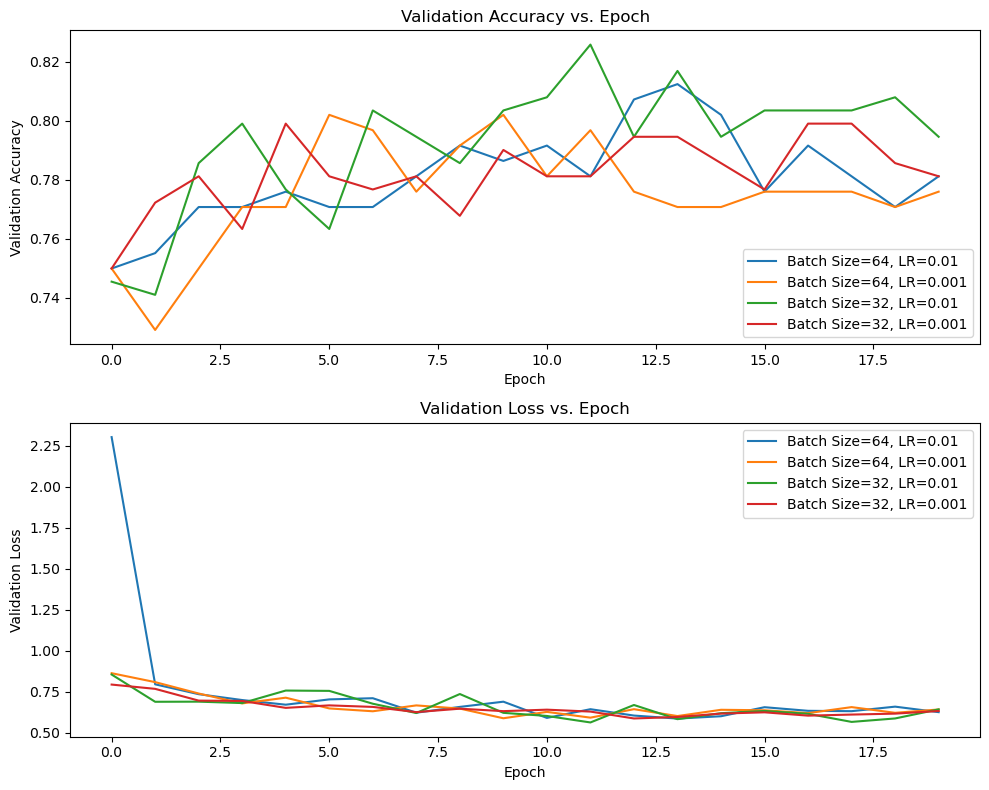

In [8]:
# Create subplots for accuracy and loss
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

for batch in batch_sizes:
    for initial_learning_ratess in initial_learning_rates:
        batch_size = batch
        initial_learning_rate = initial_learning_ratess

        save_path = f"../TrainingX/Model_{batch_size}_{initial_learning_ratess}"
        history_name = f"History_{batch_size}_{initial_learning_ratess}.pickle"

        # Load history from file
        with open(f"{save_path}/{history_name}", 'rb') as file:
            history = pickle.load(file)

        # Plot validation accuracy
        ax1.plot(history['val_accuracy'], label=f'Batch Size={batch_size}, LR={initial_learning_rate}')

        # Plot validation loss
        ax2.plot(history['val_loss'], label=f'Batch Size={batch_size}, LR={initial_learning_rate}')

print("Plotting completed for all batch sizes and learning rates")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Accuracy')
ax1.set_title('Validation Accuracy vs. Epoch')
ax1.legend()

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Validation Loss')
ax2.set_title('Validation Loss vs. Epoch')
ax2.legend()

plt.tight_layout()
plt.show()